# Introduction: Time Series Analysis and Forecasting Project

## Dataset

The data have been downloaded from the website http://rp5.ru/. The data are average daily temperatures collected by the weather station 2978 in Helsinki from January 2015 to September 2019

# Exploratory Data Analysis

## Read in Data and Examine

In [ ]:
# Import numpy, pandas for data manipulation
import numpy as np
import pandas as pd

# Import matplotlib, seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the data
weather_data = pd.read_csv('weather_data_test.csv',parse_dates=['datetime'], sep=';', decimal=','
                     , infer_datetime_format=True)

# Check the shape of the dataset
print(weather_data.shape)

# Select the datetime and the temperature columns
temp_df = weather_data[["datetime","T_mu"]]
temp_df.head(10)

(1346, 17)


,datetime,T_mu
0,2015-09-03,13.7375
1,2015-09-04,14.8250
2,2015-09-05,14.2750
3,2015-09-06,13.1250
4,2015-09-07,12.0875
5,2015-09-08,12.5375
6,2015-09-10,13.0625
7,2015-09-11,13.5375
8,2015-09-12,14.7500
9,2015-09-13,15.1375


### Dataset Explanation

In [ ]:
# Check the shape of the dataset
temp_df.shape

(1346, 2)

In [ ]:
# Select the subset data from 2016 to 2019
mask = (temp_df['datetime'] >= '2016-01-01') & (temp_df['datetime'] <= '2019-05-21')
temp_df = temp_df.loc[mask]

# Reset the index
temp_df.set_index("datetime", inplace=True)

# Inspect first 5 rows and last 5 rows of the data
from IPython.display import display
display(temp_df.head(5))
display(temp_df.tail(5))

,T_mu
datetime,
2016-01-01,-4.5500
2016-01-02,-7.0000
2016-01-03,-8.7375
2016-01-04,-11.1750
2016-01-05,-17.6250


,T_mu
datetime,
2019-05-17,13.783333
2019-05-18,15.508333
2019-05-19,16.595833
2019-05-20,17.258333
2019-05-21,18.433333


For simplicity, the T_mu column above shows the daily average temperatures in Helsinki for the first 5 days of January 2016 and last 5 days of May 2019 in Helsinki, Finland.

In [ ]:
temp_df.describe()

,T_mu
count,1228.000000
mean,6.302811
std,8.433225
min,-22.675000
25%,0.559375
50%,5.227083
75%,13.784375
max,26.145833


In [ ]:
# Output the maximum and minimum temperature date
print(temp_df.loc[temp_df["T_mu"] == temp_df["T_mu"].max()])
print(temp_df.loc[temp_df["T_mu"] == temp_df["T_mu"].min()])

                 T_mu
datetime             
2018-07-17  26.145833
              T_mu
datetime          
2016-01-07 -22.675


**Observations:**

* On 17 July 2018, Helsinki witnessed the hottest date in the 4-year period (2016–2019). The temperature was 26.1 degrees Celsius. In contrast, on 07 January 2016, Helsinki citizens saw the coldest date in the 4-year period, when the temperature dropped to as terribly low as -22.6 degrees Celsius.
* There was not a significant difference between the median and the mean, being approximately 5.8 and 6.6 degrees Celsius respectively.

### Data Visualization

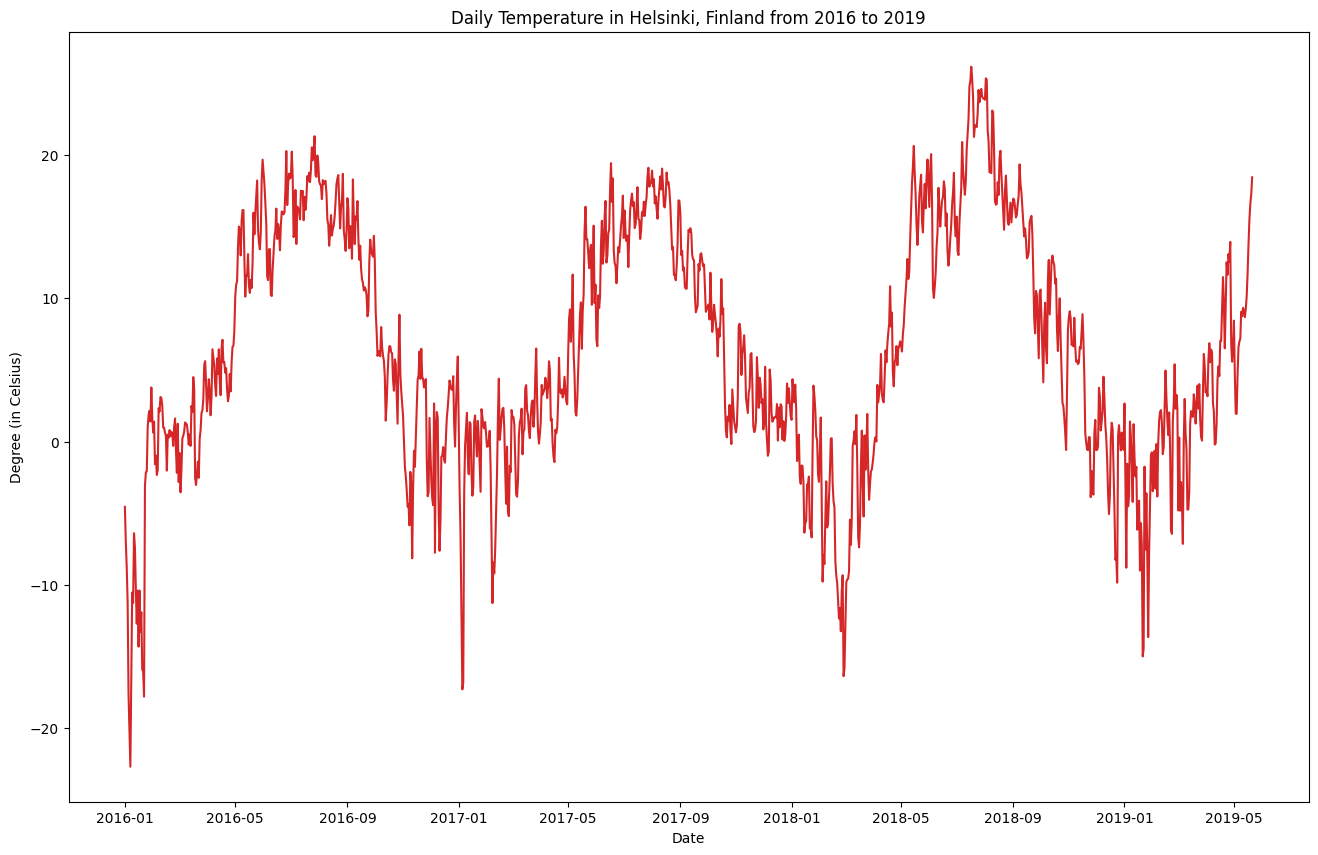

In [ ]:
# Plot the daily temperature change
plt.figure(figsize=(16,10), dpi=100)
plt.plot(temp_df.index, temp_df.T_mu, color='tab:red')
plt.gca().set(title="Daily Temperature in Helsinki, Finland from 2016 to 2019", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

The time-series has seasonality pattern, such as temperatures are always low at the beginning of the year and high at the middle of the year.


The moving average is mostly used with time series data to capture the short-term fluctuations while focusing on longer trends.

<Axes: xlabel='datetime'>

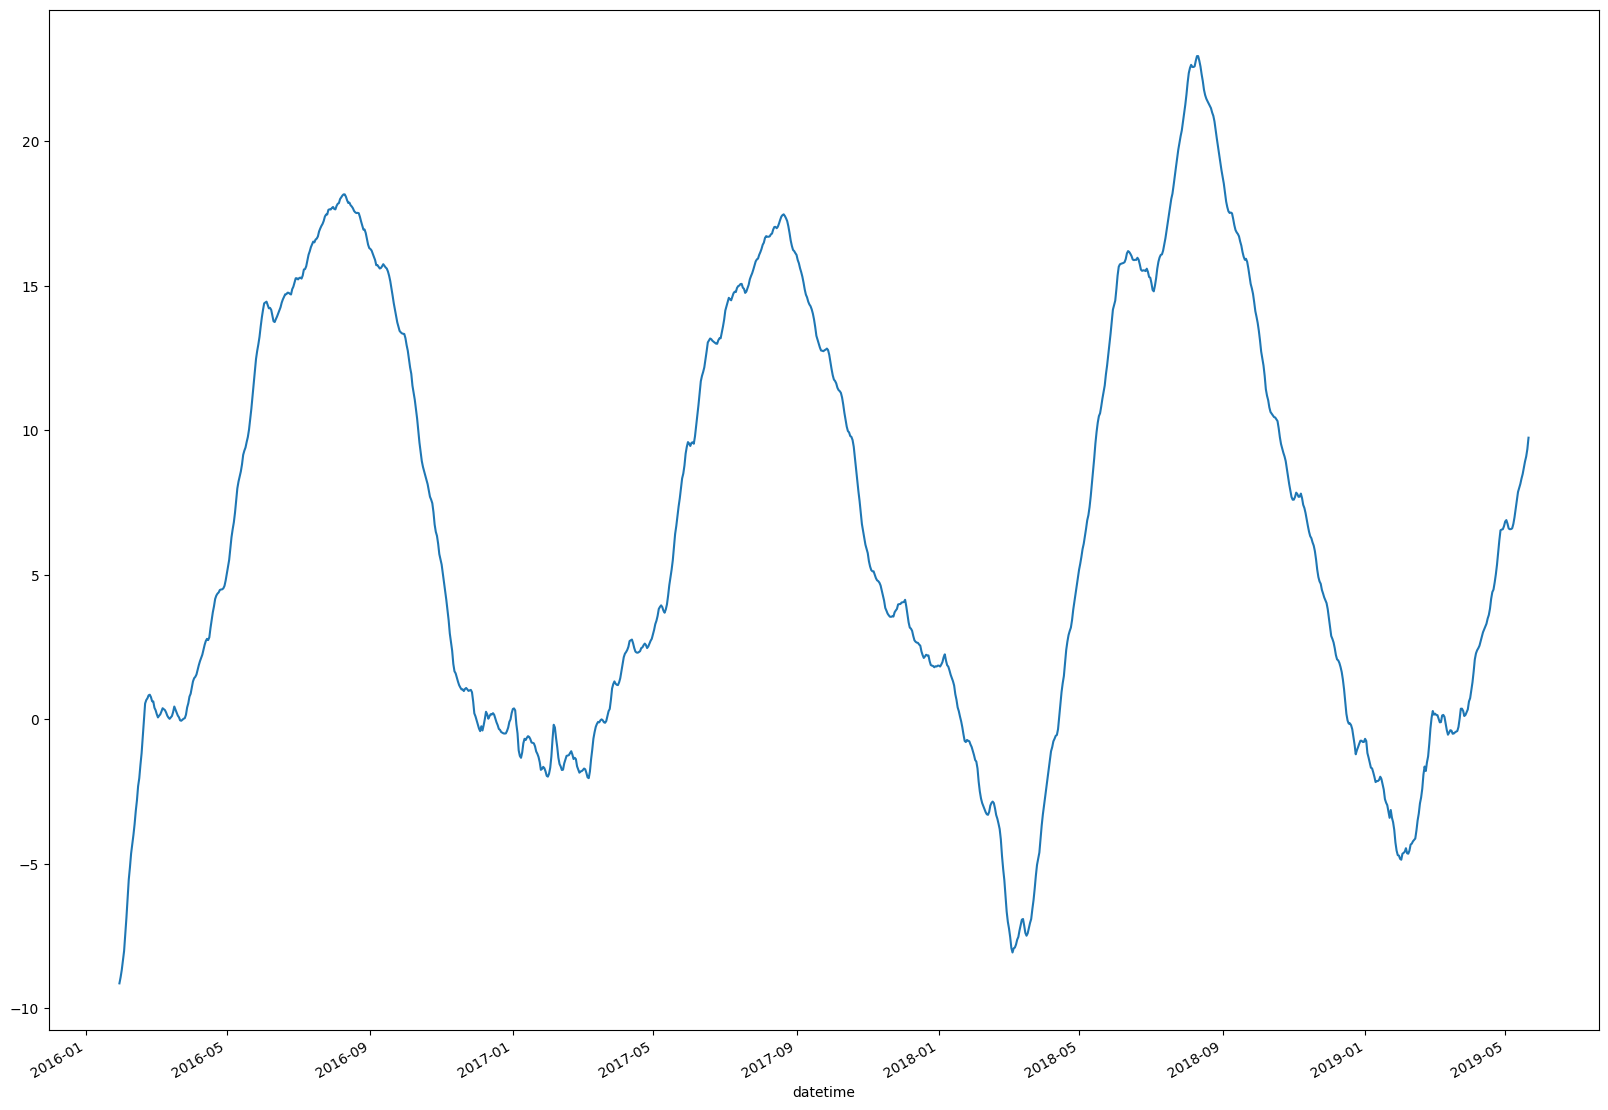

In [ ]:
# Apply the Moving Average function by a subset of size 30 days.
temp_df_mean = temp_df.T_mu.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

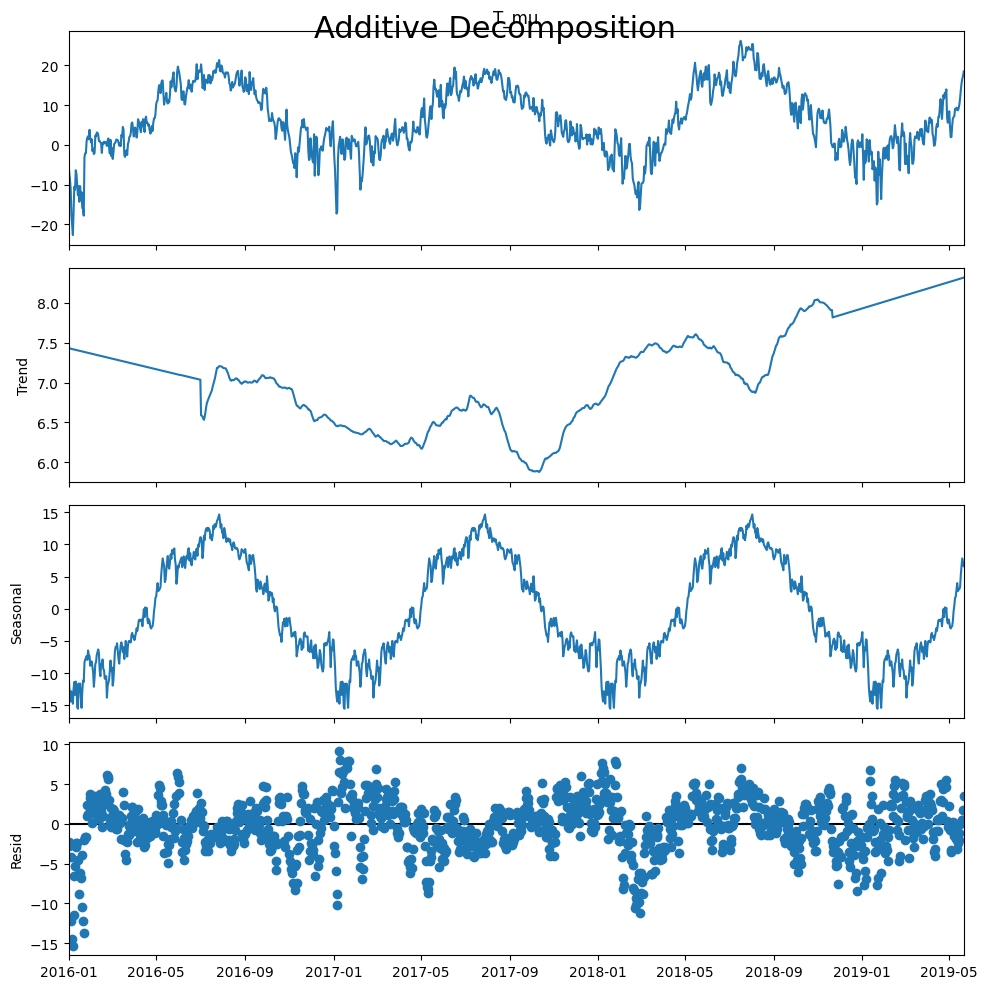

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(temp_df.T_mu, model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

 The plot above clearly shows that the temperature is unstable, along with its obvious seasonality.

## Baseline Model

Here, I use 1-step prediction to model the temperature as a time series:

In [ ]:
# Shift the current temperature to the next day.
predicted_df = temp_df["T_mu"].to_frame().shift(1).rename(columns = {"T_mu": "T_mu_pred" })
actual_df = temp_df["T_mu"].to_frame().rename(columns = {"T_mu": "T_mu_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,T_mu_actual,T_mu_pred
datetime,,
2016-01-02,-7.0000,-4.5500
2016-01-03,-8.7375,-7.0000
2016-01-04,-11.1750,-8.7375
2016-01-05,-17.6250,-11.1750
2016-01-06,-20.2625,-17.6250
2016-01-07,-22.6750,-20.2625
2016-01-08,-16.5250,-22.6750
2016-01-09,-10.5250,-16.5250
2016-01-10,-11.2500,-10.5250


We could validate how well our model is by looking at the Root Mean Squared Error(RMSE) between the predicted and actual temperature:

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.T_mu_actual, one_step_df.T_mu_pred, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 2.2618558244607696


The RMSE is small, meaning that we can use the most basic 1-step prediction baseline model to predict the upcoming day's temperature with the average error of only 2.2 degrees Celsius. The error is acceptable, especially in the Weather Forecast field in which there are many other attributes that also affect the weather (e.g wind speed, atmospheric pressure, humidity, etc).

# Weather Forecast using SARIMA model

## Parameter Selection

### Grid Search

We are going to apply one of the most commonly used method for time-series forecasting, known as SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average.
SARIMA models are denoted with the notation SARIMA(p,d,q)(P,D,Q,s). These three parameters account for seasonality, trend, and noise in data:

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal SARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [ ]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:9254.134178268685
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8346.812752927712
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7371.491452019726
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7168.973035874265
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:7216.929800741611
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7145.6695701468725
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7136.182106921272
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7877.144269133227
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:7187.634316839931
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6584.192259397732
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6309.725135554379
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6493.66897338888
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6356.147262520313
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6310.0373049130985
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6287.803447464206
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5478.290821707193
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5402.124232921584
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:6212.5223

The output of our code suggests that SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 yields the lowest AIC value of 5329.98. We should therefore consider this to be optimal option out of all the models we have considered.

## Fitting the Model

In [ ]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

## Model Diagnostics

The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior:

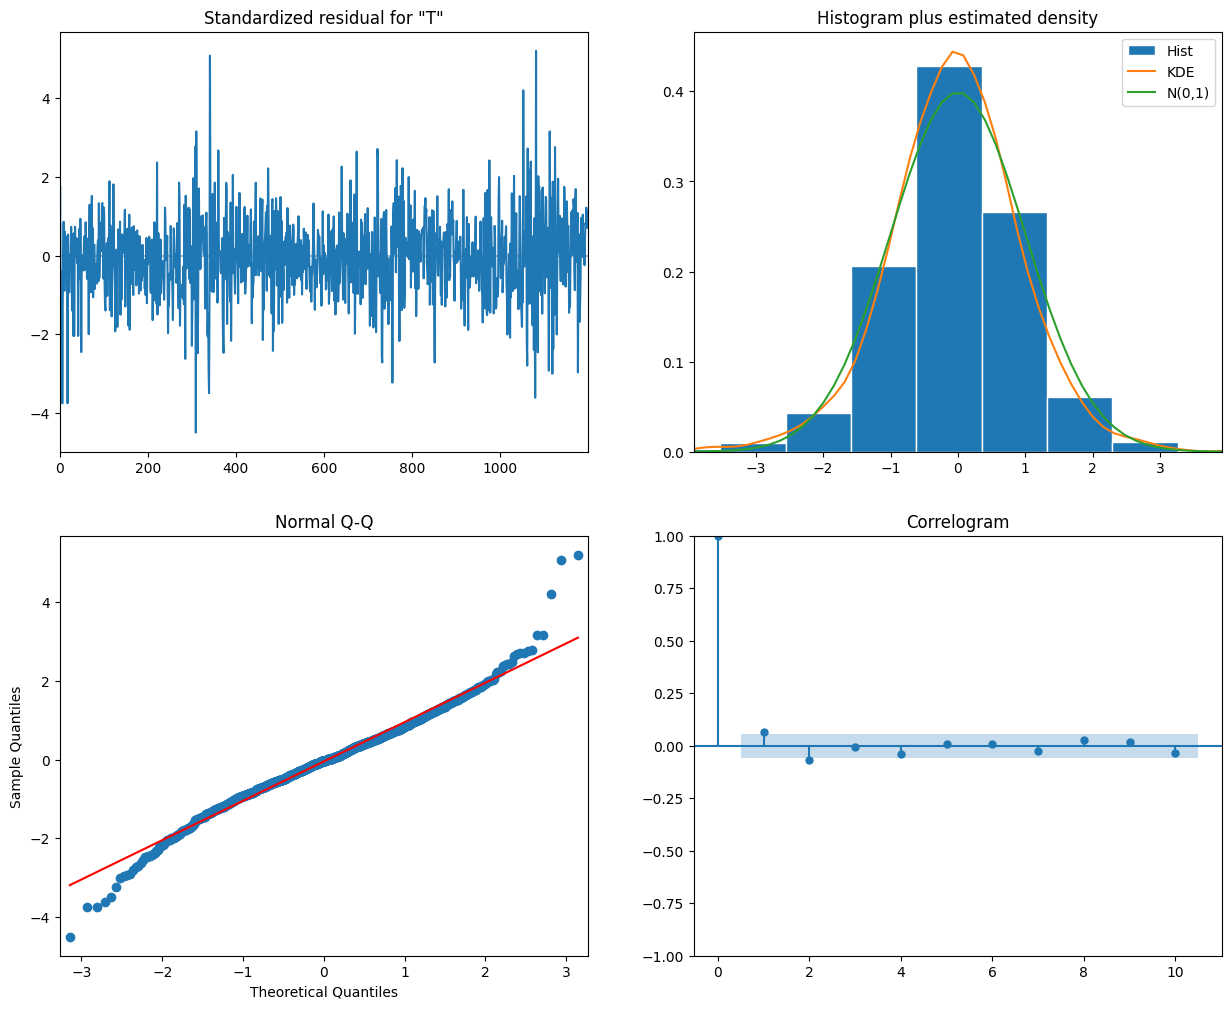

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
* The residuals over time (top left plot) do not display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

## Validating the Non-Dynamic Forecast

The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=False)
pred_ci = pred.conf_int()

The code above requires the forecasts to start at June 2017.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the average daily temperature to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.

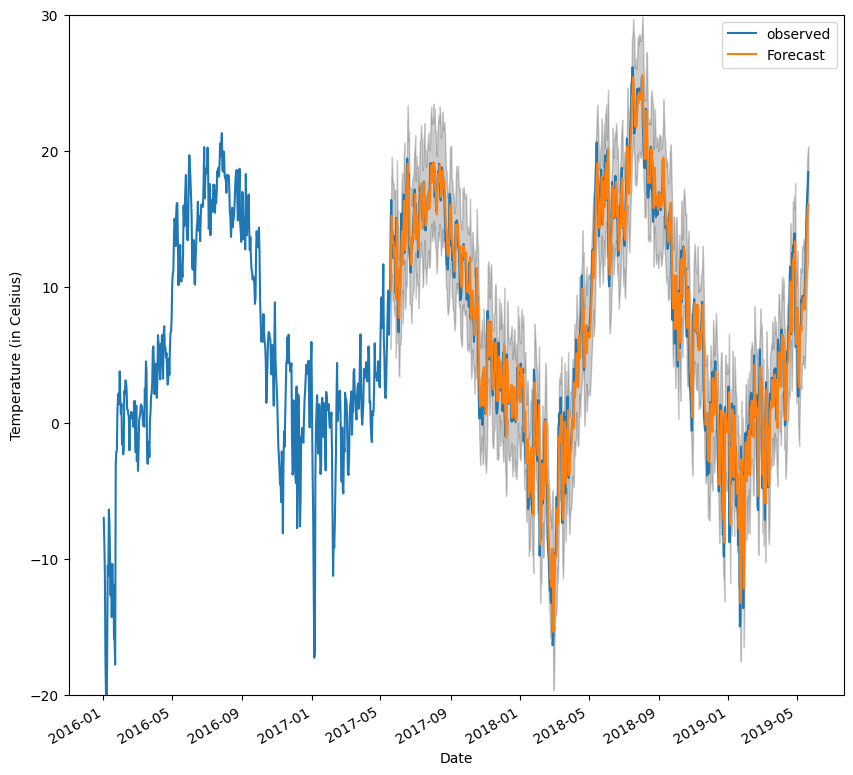

In [ ]:
ax = one_step_df.T_mu_actual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

Overall, our forecasts align with the true values very well, showing a seasonal cycle of length 365 days.

### Forecast Diagnostic

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), in which  for each predicted value, we compute its distance to the true value and square the result.

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-05-19':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(727,)
(727,)
The Mean Squared Error of our forecasts is 4.78


Our forecast model forecasts the temperature with only an error of 4.78 degrees Celsius.

## Validating the Dynamic Forecast

In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from May 2017 onwards.

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Once again, we plot the real and forecasted values of the average daily temperature to assess how well we did:

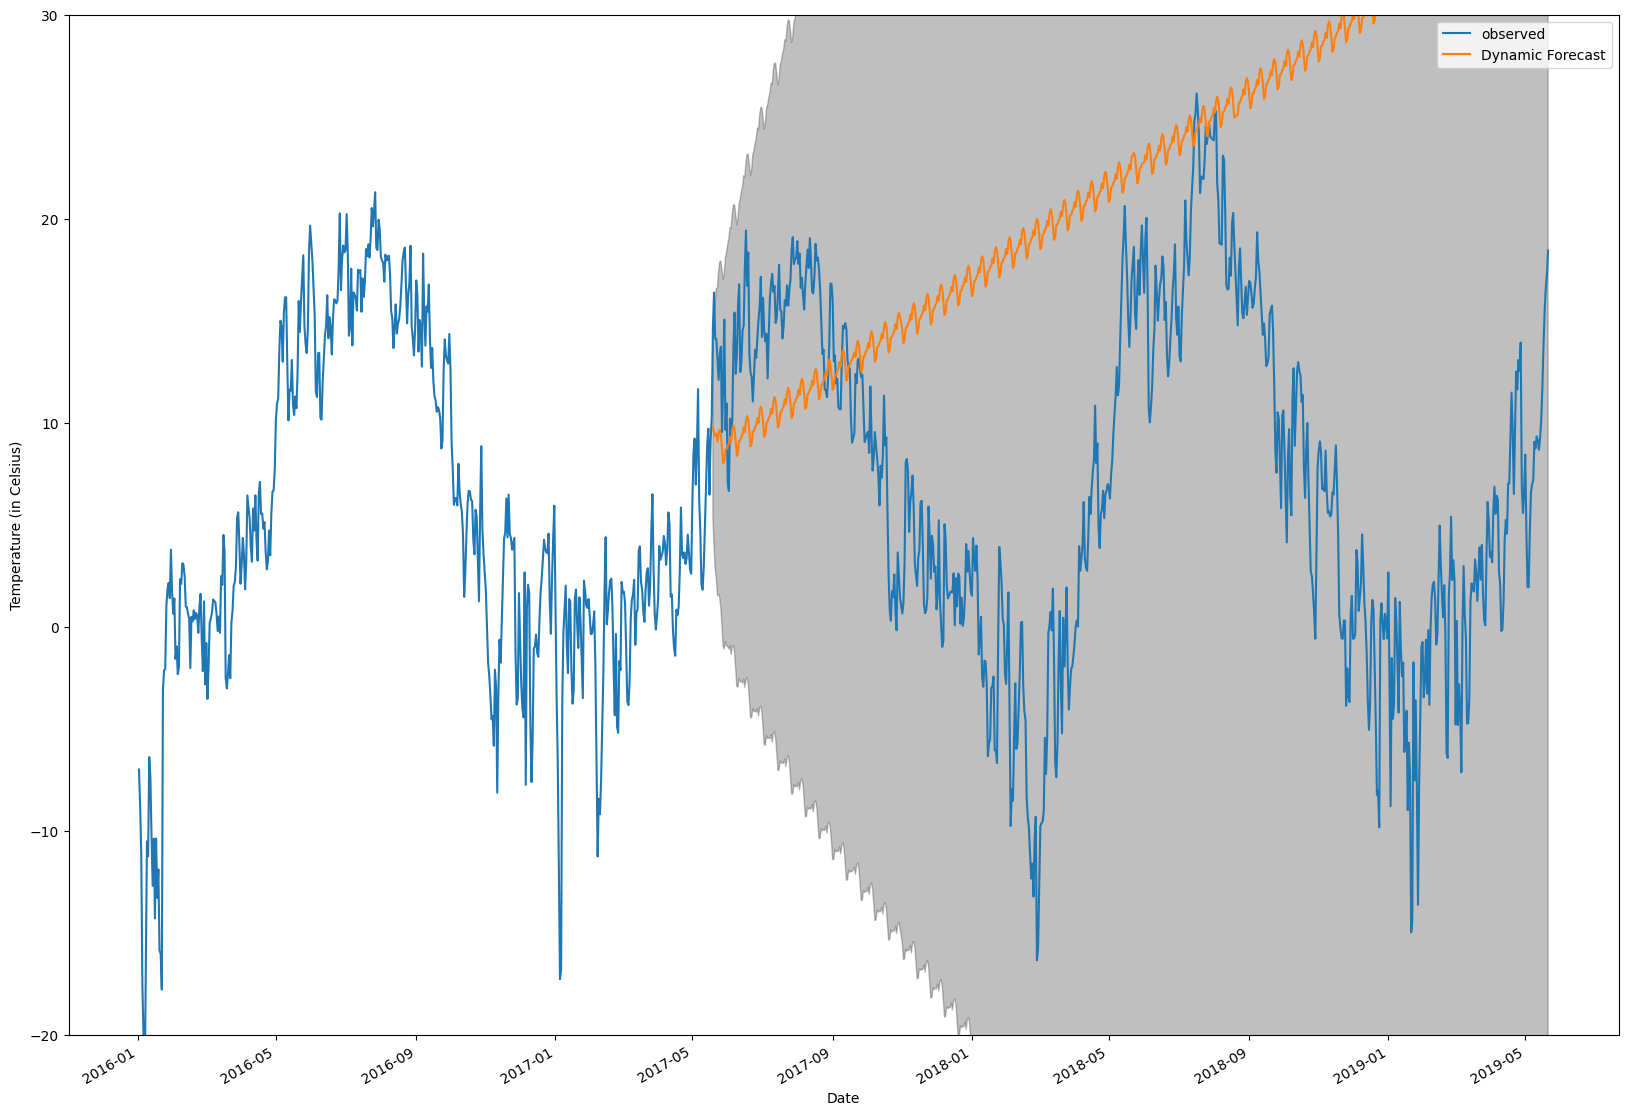

In [ ]:
ax = one_step_df.T_mu_actual['2015':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()



In this case, the model seems to predict the temperature inaccurately, with major fluctuations between the true value and the predicted value.

### Forecast Diagnostic

Once again, we measure the goodness of our model using RMSE:

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-05-19':]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 20.04


The predicted values obtained from the dynamic forecasts yield an MSE of 20.04. This is significantly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.